In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import json
import numpy as np
from shapely.geometry import Point, Polygon
from utils.geo_plot import setup_ax, plot_locs

from typing import Dict, Iterable, List, Optional

import importlib
import preprocessing.create_folds_b
importlib.reload(preprocessing.create_folds_b)

<module 'preprocessing.create_folds_b' from 'c:\\Users\\Benjamin\\Desktop\\Exjobb\\CreateFolds\\preprocessing\\create_folds_b.py'>

# Read data and remove points to break cluster chains

In [2]:
dhs_df_og = pd.read_csv('../dhs_clusters.csv', float_precision='high', index_col=False)

dhs_locs = dhs_df_og[['lat', 'lon']].values

fold_names = ['A', 'B', 'C', 'D', 'E']


In [4]:
# Read regions to remove from JSON
with open('remove_regions2.json') as f:
    remove_regions_gj = json.load(f)

# Create polygon regions to remove points within
remove_regions = []
for region in remove_regions_gj['features']:
    remove_regions.append(Polygon(region['geometry']['coordinates'][0]))

# Method to determine whether point lies within polygon or not
def in_polys(point, polys):
  for poly in polys:
    if point.within(poly):
      return True
  return False

# Remove points within polygons
dhs_df = dhs_df_og.copy()
dhs_df['geometry'] = dhs_df_og.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
dhs_df = dhs_df[~(dhs_df['geometry'].apply(lambda p: in_polys(p, remove_regions)))]

dhs_df = dhs_df.drop(columns='geometry')
dhs_df.head()

,country,year,lat,lon,GID_1,GID_2,households,rural,iwi
0,angola,2015,-8.589805,13.640789,AGO.1,AGO.1.2,21,0,62.334459
1,angola,2016,-7.718385,14.122619,AGO.1,AGO.1.5,9,1,8.226589
2,angola,2015,-8.592545,13.654425,AGO.1,AGO.1.2,19,0,62.760211
3,angola,2016,-8.652260,13.517859,AGO.11,AGO.11.1,12,1,68.211697
4,angola,2015,-7.852511,13.721998,AGO.1,AGO.1.1,15,1,14.825944


In [5]:
print(len(dhs_df))
print(len(dhs_df_og))

56776
57195


# Plotting and helper methods

In [6]:
def plot_splits(locs_dict, title=None):
    '''
    Args
    - locs_dict: dict, label (str) => np.array of lat, lon
    '''
    fig = plt.figure(figsize=[15, 15])
    ax = setup_ax(fig)

    for label, locs_array in locs_dict.items():
        ax.scatter(locs_array[:, 1], locs_array[:, 0], label=label, s=2)

    lgd = ax.legend()
    for handle in lgd.legendHandles:
        handle.set_sizes([50.0])

    if title is not None:
        ax.set_title(title)
    plt.show()

In [7]:
def plot_iwi_distribution(dhs_df, folds, plot_title):

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    plt.figure(figsize=(20, 10), dpi=80)
    fig, axes=plt.subplots(1,1, figsize=(20,10))
    for i, fold in enumerate(folds.keys()):
        x = dhs_df['iwi'].loc[folds[fold]].values
        plt.axvline(x=np.mean(x), color=colors[i], alpha=0.4)
        ax=sns.kdeplot(data=x, color=colors[i])
        
        print("fold {} - MEAN: ".format(fold), np.mean(x), ", STD DEV: ", np.std(x))

    fig.legend(labels=folds.keys(), prop={'size': 20})
    ax.yaxis.label.set_size(24)
    ax.xaxis.label.set_size(24)
    plt.xticks(fontsize=22, rotation=90)
    plt.yticks(fontsize=18, rotation=90)
    plt.xlabel('IWI')
    plt.ylabel('Density')
    plt.title(plot_title, fontsize=22)

    plt.show()

In [8]:
def divide_safely_by_zero(x, y):
    if y == 0:
        return 0
    else:
        return x / y

## Creating .py-method
### Use preprocessing.create_folds_b.create_country_folds() instead

In [55]:
big_fold_penalty = 212312300

# Group DataFrame by countries
grouped = dhs_df.groupby('country')

# Get all indices pertaining to every country 
country_indices_dict = grouped.groups

# Find max fold size
MAX_FOLD_SIZE = int(len(dhs_df.index) / len(fold_names) + 100)

# Find mean of IWI for all clusters
tot_mean = dhs_df['iwi'].mean()

folds: Dict[str, List[int]] = {f: [] for f in fold_names}

folds_sum: Dict[str, List[int]] = {f: 0 for f in fold_names}
folds_count: Dict[str, List[int]] = {f: 0 for f in fold_names}

# Sort countries by size, in order to assign the largest countries first
countries_sorted = sorted(country_indices_dict.keys(), key= lambda f: -len(country_indices_dict[f]))

# Assign countries to folds
for country in countries_sorted:

    # Get all indices for current country
    country_indices = country_indices_dict[country]

    # Calculate sum of IWI in, and number of DHS clusters in current country
    country_tot_iwi = dhs_df.loc[country_indices]['iwi'].sum()
    n_surveys_in_country = len(country_indices)


    # Find "suitableness" of assigning the current country to each fold, and assign to most suitable fold
    fold_suitableness: Dict[str, List[int]] = {f: 0 for f in fold_names}
    for fold in fold_names:
        
        # Suitableness 4: assign to smallest fold
        #suitableness = folds_count[fold]

        # Suitableness 3: dist to real mean after assigning to cluster + penalty for assigning to large fold
        #suitableness = folds_count[fold] / big_fold_penalty  \
        #    + abs( tot_mean - ( (folds_sum[fold] + country_tot_iwi) / (folds_count[fold] + n_surveys_in_country) ))

        # Suitableness 1.5: (dist to real mean before assigning cluster) - (dist to real mean after assigning to cluster) + penalty for assigning to large fold
        #suitableness = folds_count[fold] / big_fold_penalty - abs(tot_mean - divide_safely_by_zero(folds_sum[fold], folds_count[fold])) - abs( tot_mean - ( (folds_sum[fold] + country_tot_iwi) / (folds_count[fold] + n_surveys_in_country) ) )
            
        # Suitableness 2: dist to real mean after assigning to cluster
        suitableness = abs( tot_mean - ( (folds_sum[fold] + country_tot_iwi) / (folds_count[fold] + n_surveys_in_country) )) 

        fold_suitableness[fold] = suitableness

    # Sort fold names based on their suitableness for being assigned current country
    fold_suitableness_sorted = sorted(fold_suitableness.keys(), key= lambda f: fold_suitableness[f])

    # Assign current country to most suitable fold AS LONG AS it does not fill it over the maximum fold size.
    # Otherwise, assign to next, non-full, most suitable fold
    fold_suitable_index = 0
    while folds_count[fold_suitableness_sorted[fold_suitable_index]] + n_surveys_in_country > MAX_FOLD_SIZE:
        fold_suitable_index += 1
    fold_assigned = fold_suitableness_sorted[fold_suitable_index]

    # Increase fold counters
    folds_count[fold_assigned] += n_surveys_in_country
    folds_sum[fold_assigned] += country_tot_iwi

    # Assign indices of all clusters within country to fold
    folds[fold_assigned].extend(country_indices)



# Create and plot country TEST folds

FOLD SIZES:
A :  11260
B :  11271
C :  11348
D :  11475
E :  11422


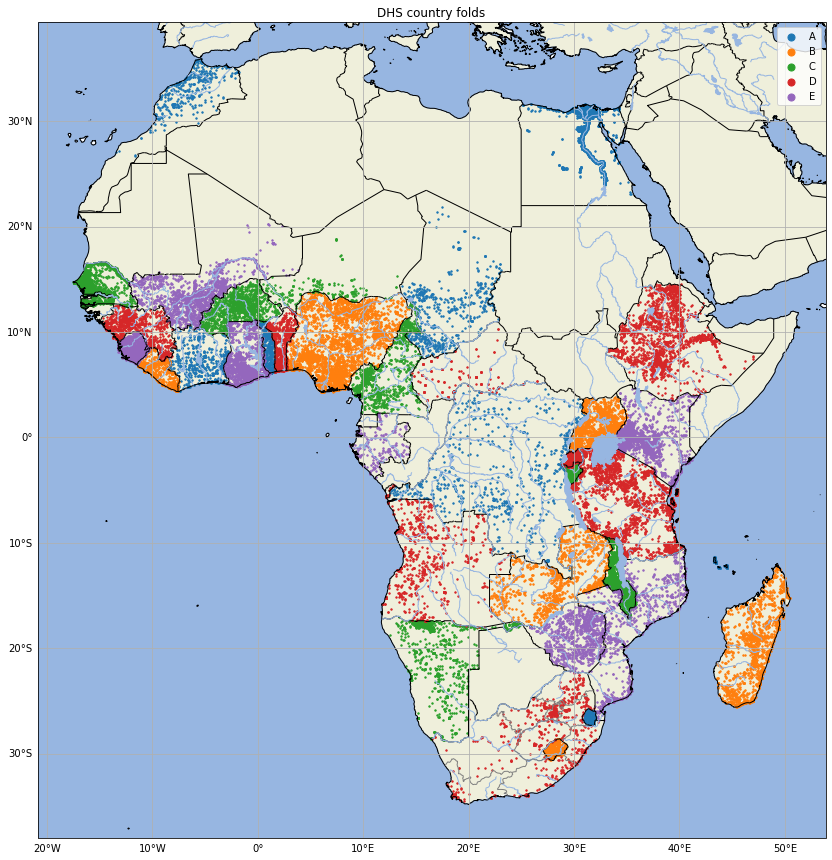

fold A - MEAN:  49.33900564334876 , STD DEV:  20.1964417348211
fold B - MEAN:  28.488659172044333 , STD DEV:  16.72533440944959
fold C - MEAN:  27.563607694940718 , STD DEV:  16.210863859750773
fold D - MEAN:  26.066238634096255 , STD DEV:  17.56194118432356
fold E - MEAN:  29.22607708810473 , STD DEV:  15.882732541638838


<Figure size 1600x800 with 0 Axes>

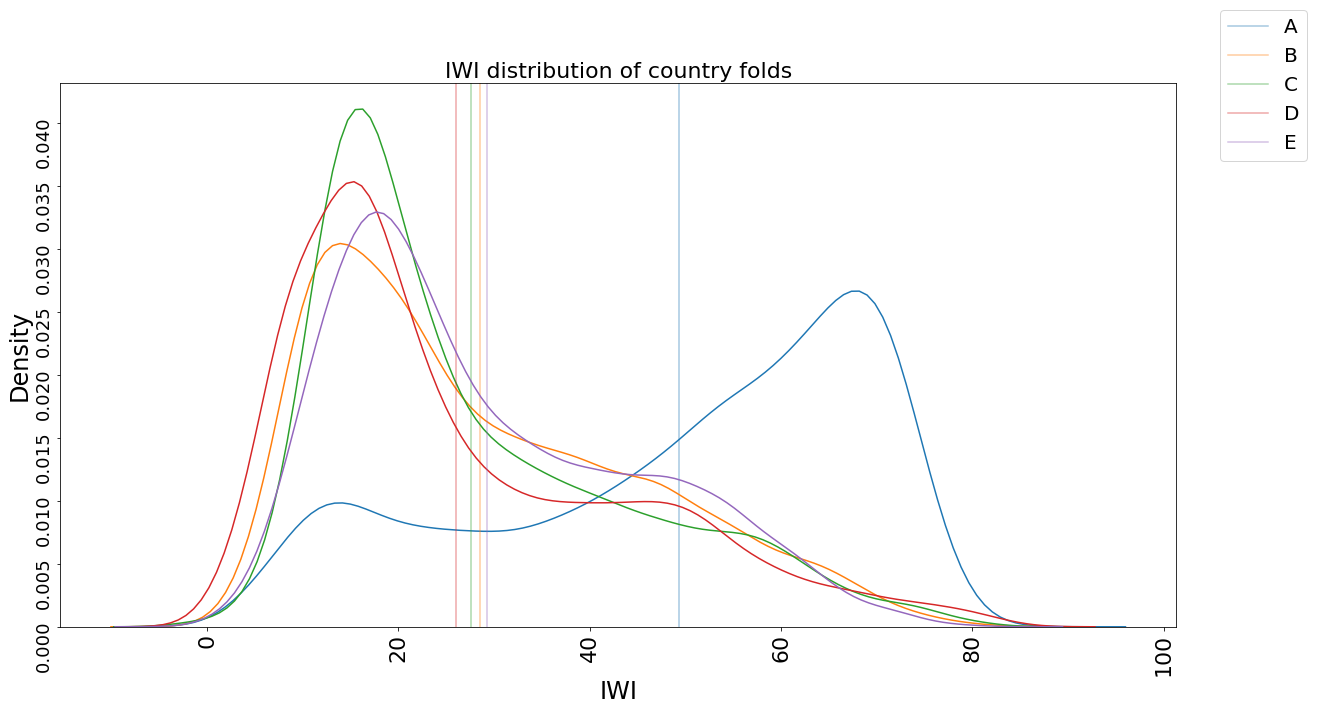

A :  ['egypt', 'democratic_republic_of_congo', 'togo', 'ivory_coast', 'chad', 'morocco', 'eswatini', 'comoros']
B :  ['nigeria', 'uganda', 'madagascar', 'zambia', 'lesotho', 'liberia']
C :  ['malawi', 'senegal', 'burkina_faso', 'cameroon', 'namibia', 'burundi', 'niger']
D :  ['tanzania', 'ethiopia', 'benin', 'rwanda', 'guinea', 'angola', 'south_africa', 'central_african_republic']
E :  ['kenya', 'ghana', 'mali', 'sierra_leone', 'zimbabwe', 'mozambique', 'gabon']


In [9]:
importlib.reload(preprocessing.create_folds_b)

# Create folds
country_folds, countries_in_folds = preprocessing.create_folds_b.create_country_folds(dhs_df, fraction=1, big_fold_penalty=150)

print("FOLD SIZES:")
for fold in country_folds:
    print(fold, ": ", len(country_folds[fold]))

plot_splits({f: dhs_locs[country_folds[f]] for f in fold_names},
            title='DHS country folds')
            
plot_iwi_distribution(dhs_df, country_folds, plot_title='IWI distribution of country folds')

for fold in countries_in_folds.keys():
    print(fold, ": ", countries_in_folds[fold]) 

# Create train and validation folds from remaining countries

In [10]:
def select_representative_fold(df_train_val, folds, prints=False):
    means = {f: df_train_val['iwi'].loc[folds[f]].mean() for f in folds.keys()}
    mean_tot = df_train_val['iwi'].mean()
    mean_diff = {f: abs(means[f] - mean_tot) for f in folds.keys()}

    stds = {f: df_train_val['iwi'].loc[folds[f]].std() for f in folds.keys()}
    std_tot = df_train_val['iwi'].std()
    std_diff = {f: abs(stds[f] - std_tot) for f in folds.keys()}

    # Weigh having correct mean more important than standard deviation
    tot_diff = {f: mean_diff[f] + std_diff[f]/2 for f in folds.keys()}
    val_fold = min(tot_diff, key=tot_diff.get)

    if prints:
        print("MEANS: ")
        print("Folds: ", means)
        print("Total: ", mean_tot)
        print("Diff: ", mean_diff)
        print()
        print("STDS: ")
        print("Folds: ", stds)
        print("Total: ", std_tot)
        print("Diff: ", std_diff)
        print()
        print("TOTAL DIFF SCORE: ", tot_diff)
        print()
        print("Most representative fold: ", val_fold)


    return val_fold

FOLD:  A
num clusters: 3990
num outliers: 6588
max cluster size (excl. outliers): 1954


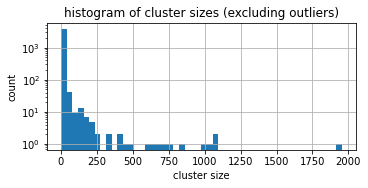

fold B - MEAN:  27.78473843303287 , STD DEV:  16.91895012861951
fold C - MEAN:  27.790650198920662 , STD DEV:  16.65686902608604
fold D - MEAN:  27.774287619764078 , STD DEV:  16.01753349643286
fold E - MEAN:  27.97982794763882 , STD DEV:  16.991219957897552


<Figure size 1600x800 with 0 Axes>

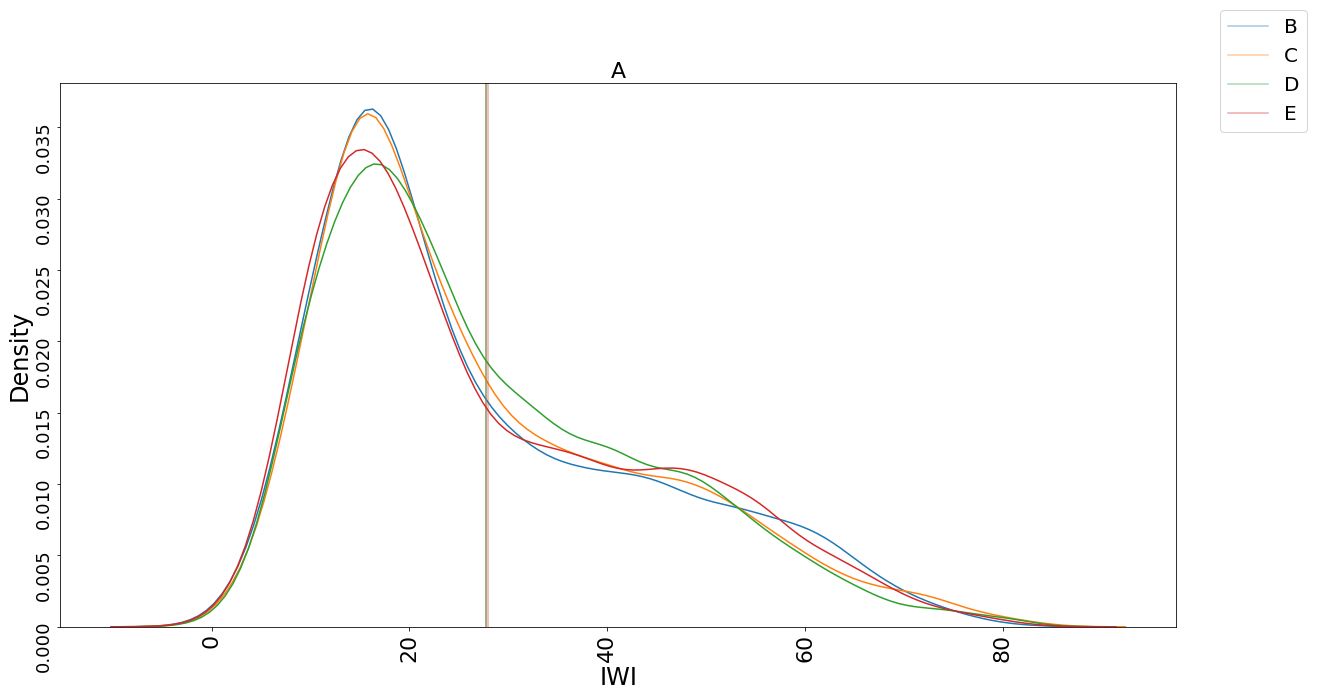

_____________________
FOLD:  B
num clusters: 3274
num outliers: 5973
max cluster size (excl. outliers): 1920


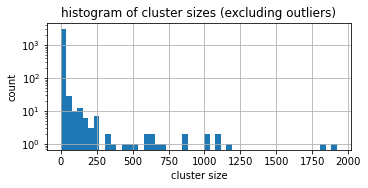

fold A - MEAN:  33.94687151128075 , STD DEV:  20.27875095311978
fold C - MEAN:  32.66285823954561 , STD DEV:  20.36727450861225
fold D - MEAN:  32.70479408477297 , STD DEV:  20.241702993293618
fold E - MEAN:  32.65182978199888 , STD DEV:  18.701813666249848


<Figure size 1600x800 with 0 Axes>

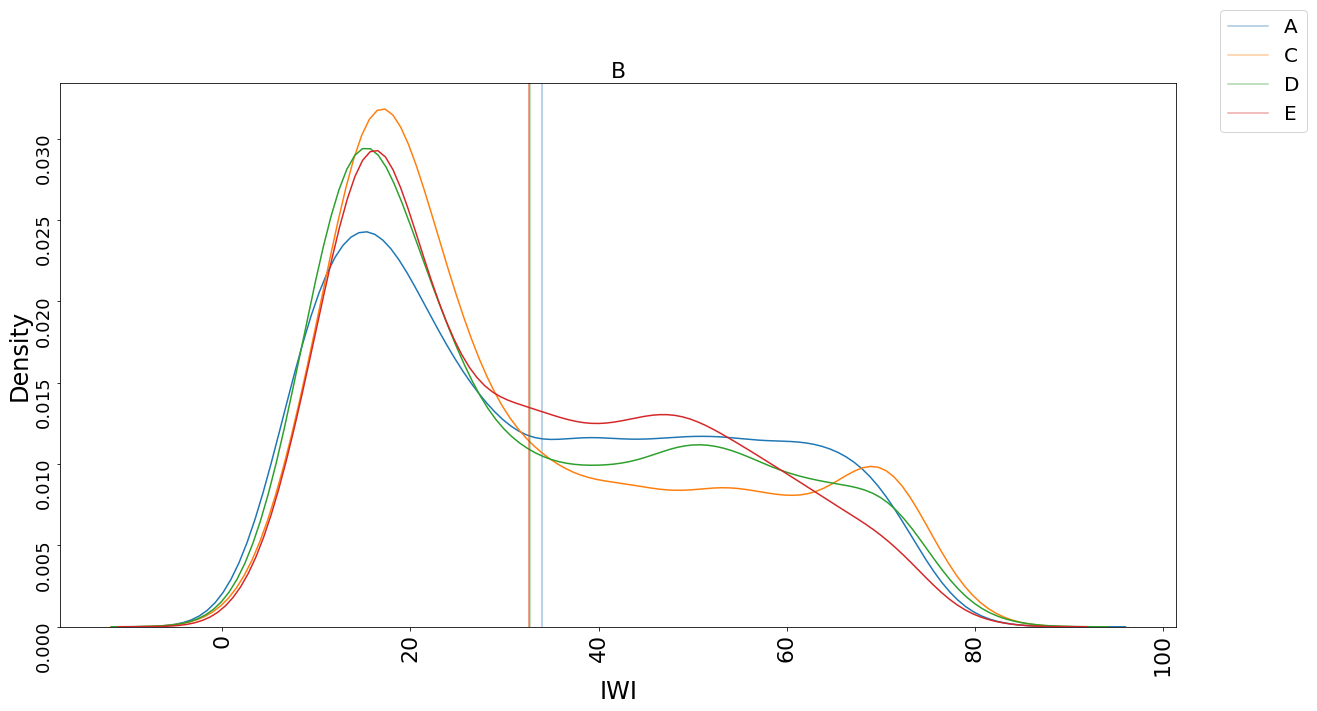

_____________________
FOLD:  C
num clusters: 3761
num outliers: 6908
max cluster size (excl. outliers): 1920


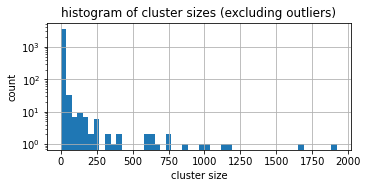

fold A - MEAN:  33.637510309350915 , STD DEV:  20.400773082345307
fold B - MEAN:  33.13788832067717 , STD DEV:  21.475228428437475
fold D - MEAN:  33.10259369976338 , STD DEV:  19.339848950375952
fold E - MEAN:  33.04310046295752 , STD DEV:  18.52850714857467


<Figure size 1600x800 with 0 Axes>

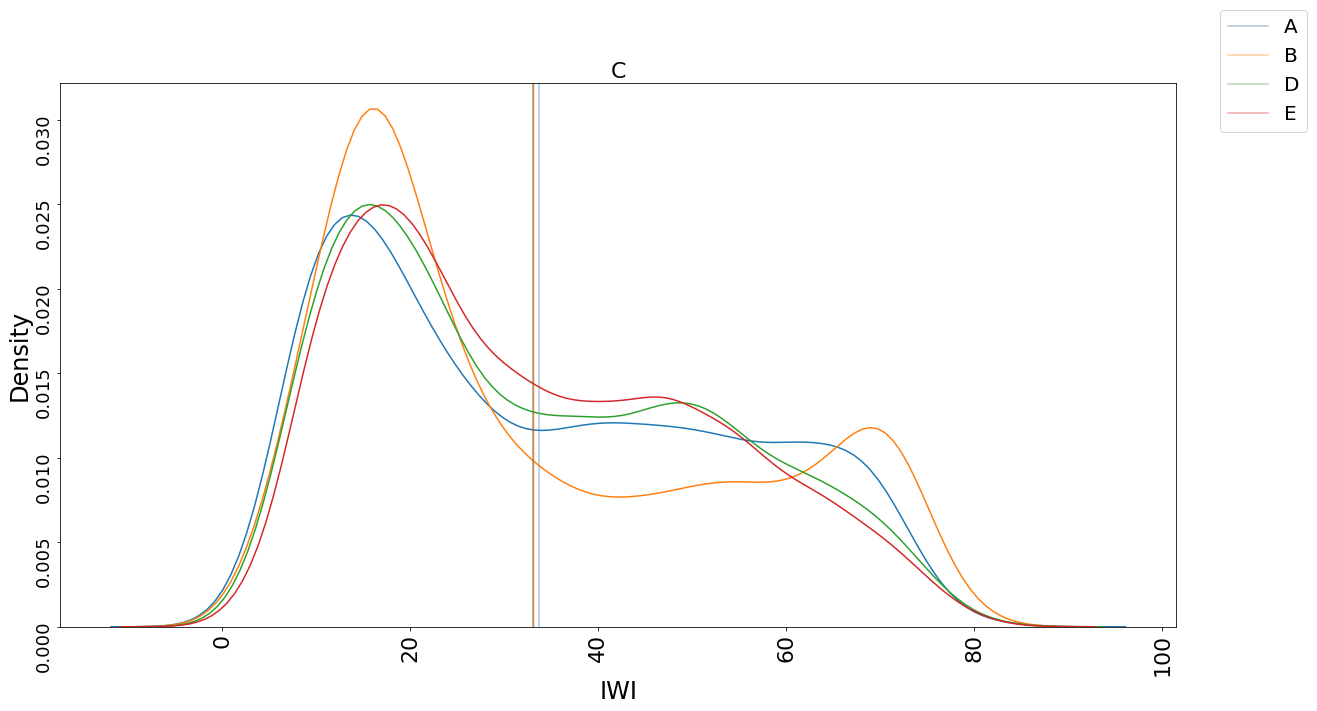

_____________________
FOLD:  D
num clusters: 3317
num outliers: 5941
max cluster size (excl. outliers): 1920


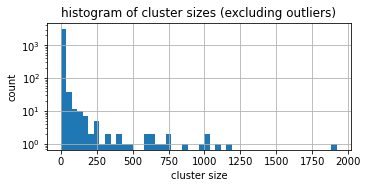

fold A - MEAN:  33.957850187958684 , STD DEV:  20.30111877100071
fold B - MEAN:  34.12691081563102 , STD DEV:  20.36627036173907
fold C - MEAN:  33.27297106302393 , STD DEV:  19.258128314616002
fold E - MEAN:  33.14406330926355 , STD DEV:  18.200743470837


<Figure size 1600x800 with 0 Axes>

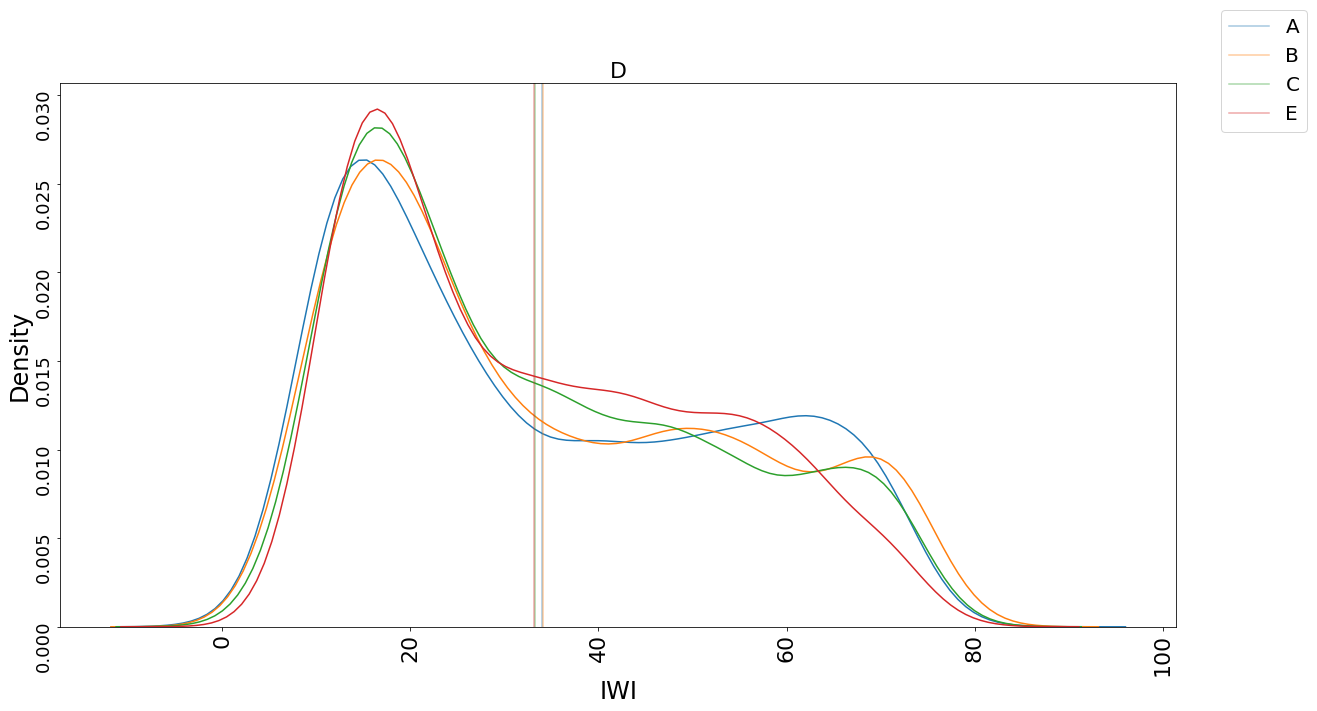

_____________________
FOLD:  E
num clusters: 3454
num outliers: 6128
max cluster size (excl. outliers): 1963


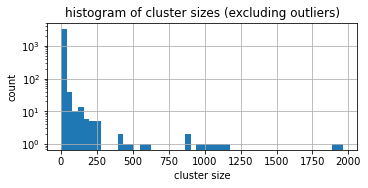

fold A - MEAN:  32.67729086264142 , STD DEV:  21.066117391018967
fold B - MEAN:  33.172564935498364 , STD DEV:  20.9813588685326
fold C - MEAN:  32.76131072732816 , STD DEV:  19.844750243232
fold D - MEAN:  32.67211547916486 , STD DEV:  18.5409417505197


<Figure size 1600x800 with 0 Axes>

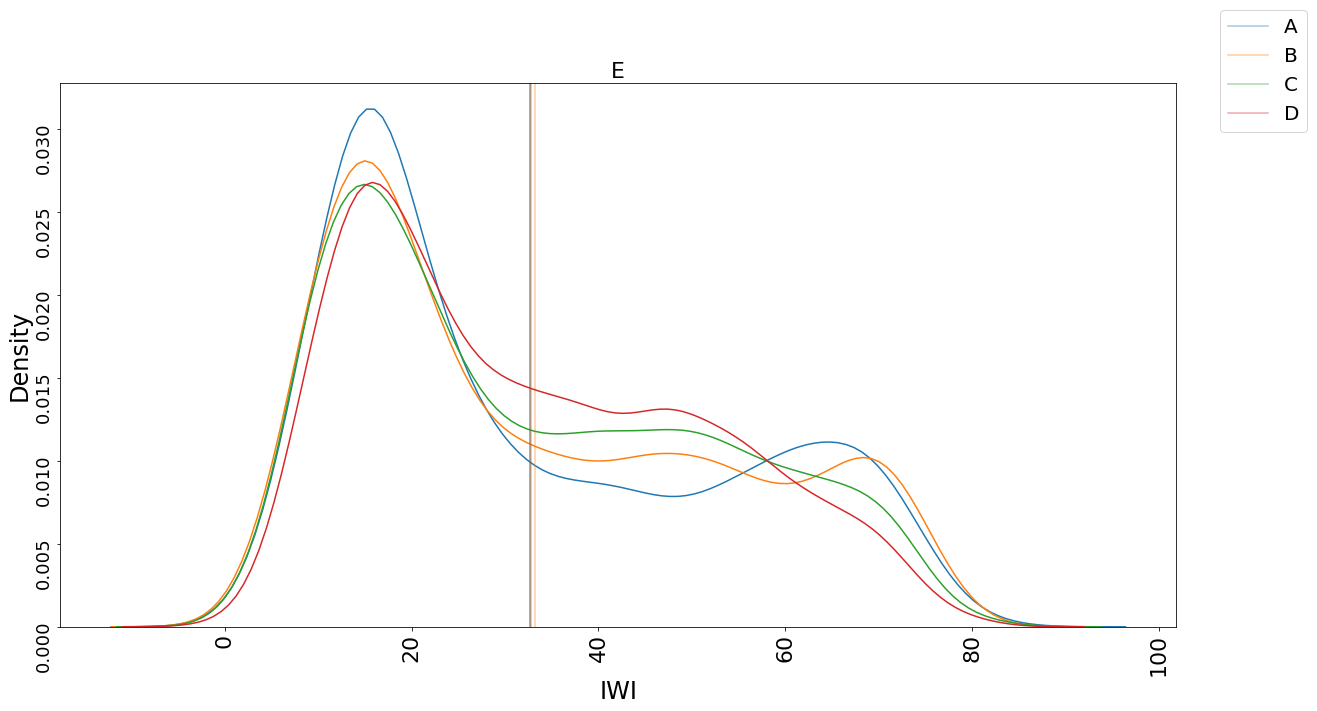

_____________________
A :  train :  34136
A :  val :  11380
A :  test :  11260

B :  train :  34128
B :  val :  11377
B :  test :  11271

C :  train :  34070
C :  val :  11358
C :  test :  11348

D :  train :  33975
D :  val :  11326
D :  test :  11475

E :  train :  34015
E :  val :  11339
E :  test :  11422



In [11]:
# country_folds: TEST FOLDS
# dhs_df

importlib.reload(preprocessing.create_folds_b)

# DOES NOT WORK WITH FRACTIONS
split_folds = {}
for test_fold in country_folds.keys():
    print("FOLD: ", test_fold)

    split_folds[test_fold] = {}

    # Create new DataFrame with just train and val data
    train_val_indices = np.setdiff1d(dhs_df.index.values, country_folds[test_fold])
    df_train_val = dhs_df.loc[train_val_indices]

    # Create four folds from train and val data
    train_val_fold_names = list(country_folds.keys())
    train_val_fold_names.remove(test_fold)
    train_val_folds = preprocessing.create_folds_b.create_folds(df=df_train_val, fold_names=train_val_fold_names, random_state=1338, big_fold_penalty=150)

    plot_iwi_distribution(df_train_val, train_val_folds, test_fold)

    val_fold = select_representative_fold(df_train_val, train_val_folds)
    #train_folds = train_val_fold_names.remove(val_fold)

    # Assign test data
    split_folds[test_fold]['test'] = country_folds[test_fold]

    # Assign validation data
    split_folds[test_fold]['val'] = train_val_folds[val_fold]
    
    # Assign training data
    train_indices = np.setdiff1d(train_val_indices, train_val_folds[val_fold])
    split_folds[test_fold]['train'] = train_indices

    print("_____________________")

for fold in fold_names:
    for dataset in ['train', 'val', 'test']:
        print(fold, ": ", dataset, ": ", len(split_folds[fold][dataset]))
    print()



In [311]:
# SAVE FOLDS
preprocessing.create_folds_b.save_folds(
   folds_path='dhs_country_folds.pkl',
   folds=split_folds,
   check_exists=False)

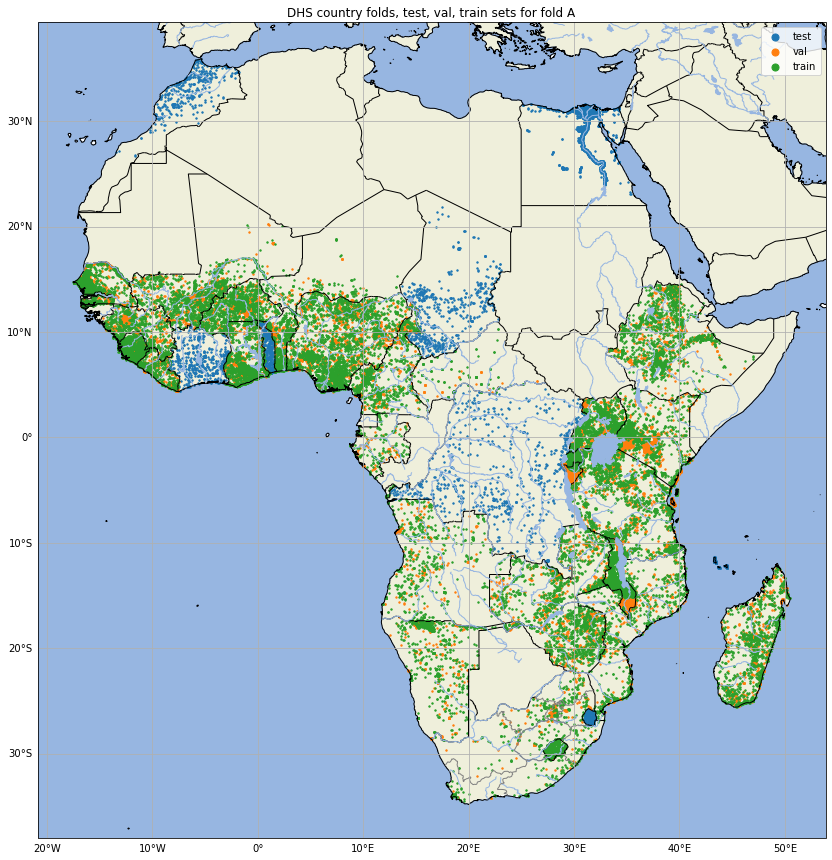

In [14]:
plot_splits({f: dhs_locs[split_folds['A'][f]] for f in split_folds['A']},
            title='DHS country folds, test, val, train sets for fold A')